## Check on GPU


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5305ea78-4dc2-65fb-b2c4-e9c69c4f4d8f)


## Getting Our Data

In [2]:
# Clone our data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

## Becoming one with our data

In [6]:
import os
filenames = [filename for filename in os.listdir(data_dir)]
filenames

['dev.txt', 'train.txt', 'test.txt']

### Create Function to get lines of txt file

In [7]:
def get_lines(filepath):
  """
  Reads txt file then return lines of txt in list
  """

  with open(filepath, 'r') as file:
    return file.readlines()

In [8]:
# test our functions
train_lines = get_lines(data_dir + 'train.txt')
dev_lines = get_lines(data_dir + 'dev.txt')
test_lines = get_lines(data_dir + 'test.txt')
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

### create function that take lines and split text as corresponding target
in something like that
```
{'lin_num':0,
'target':BACKGROUND,
'text': it's ........,
'total_num':11,......}
```

In [9]:
def preprocess_txt_with_line_num(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  # Get lines
  input_lines = get_lines(filename)

  abstract_lines = ''    # that saving lines of each part
  abstract_samples = [] # list for saving dicts

  for line in input_lines :
    # check if it start of line
    if line.startswith("###") :
      abstract_lines = ''

    # check if it end of line
    elif line.isspace():
      # Get list of each line in the part because it's ending with space ('\n')
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_num, abstract_line in enumerate(abstract_line_split):
        line_data = {}

        # spilt one line into target and txt
        target_txt_split = abstract_line.split("\t")

        # fill data in dict
        line_data['target'] = target_txt_split[0]
        line_data['text'] = target_txt_split[1].lower()
        line_data['line_num'] = abstract_line_num
        line_data['tot_lines'] = len(abstract_line_split) - 1

        # append that into list of dicts
        abstract_samples.append(line_data)

    # check if we between start and end
    else :
      abstract_lines += line

  return abstract_samples

In [10]:
# test our function
train_samples = preprocess_txt_with_line_num(data_dir + 'train.txt')
dev_samples = preprocess_txt_with_line_num(data_dir + 'dev.txt')
test_samples = preprocess_txt_with_line_num(data_dir + 'test.txt')
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_num': 0,
  'tot_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_num': 1,
  'tot_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_num': 2,
  'tot_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_num': 3,
  'tot_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontario and mcmaster unive

## Visualize our samples

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)

train_df.head()

,target,text,line_num,tot_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
test_df.head()

,target,text,line_num,tot_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


### Get sentences of our data

In [13]:
# get sentences of our dataset
train_sentences = train_df['text'].to_list()
dev_sentences = dev_df['text'].to_list()
test_sentences = test_df['text'].to_list()

train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Convert our labels into nums

**Method1:** with one hot encoder

In [14]:
# Method 1
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

# Conert labels into one_hot
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))
dev_labels_one_hot = one_hot_encoder.transform(dev_df['target'].to_numpy().reshape(-1, 1))

train_labels_one_hot.shape # for each text there are 5 classes

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(180040, 5)

In [15]:
# Method 2
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Conert labels into labels
train_labels_decoded = label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_decoded = label_encoder.transform(test_df['target'].to_numpy())
dev_labels_decoded = label_encoder.transform(dev_df['target'].to_numpy())

train_labels_decoded.shape # for each text there 1 predict

(180040,)

### Get `class names` nad `class nums`

In [16]:
class_names = label_encoder.classes_
class_nums = len(label_encoder.classes_)
class_names, class_nums

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

## Model_0 Building, compiling and fitting

In [17]:
# create nmodel_0
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# creter model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), # convert text into nums
    ('cls', MultinomialNB())      # model our data
])

# fit model to data
model_0.fit(X=train_sentences,
            y=train_labels_decoded)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('cls', MultinomialNB())])

In [18]:
# evaluate on our model
model_0.score(dev_sentences, dev_labels_decoded)

0.7218323844829869

### Predicting and calc results for model_0

In [19]:
# Let's make a predictions
model_0_preds = model_0.predict(dev_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [20]:
# Calculate results
!wget https://raw.githubusercontent.com/es-OmarHani/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import calculate_results

--2023-09-26 22:07:56--  https://raw.githubusercontent.com/es-OmarHani/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-26 22:07:56 (80.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [21]:
# calc results
model_0_res = calculate_results(y_true=dev_labels_decoded,
                                y_pred=model_0_preds )

model_0_res

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Perpare our data for vectorization and Embeddings

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [23]:
# get avg length of our scentences
sen_len = sum([len(sen.split()) for sen in train_sentences])
sen_len_avg = sen_len / len(train_sentences)
sen_len_avg

26.338269273494777

In [24]:
# get avg length of our scentences
sen_len = [len(sen.split()) for sen in train_sentences]
sen_len_avg = np.mean(sen_len)
sen_len_avg

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

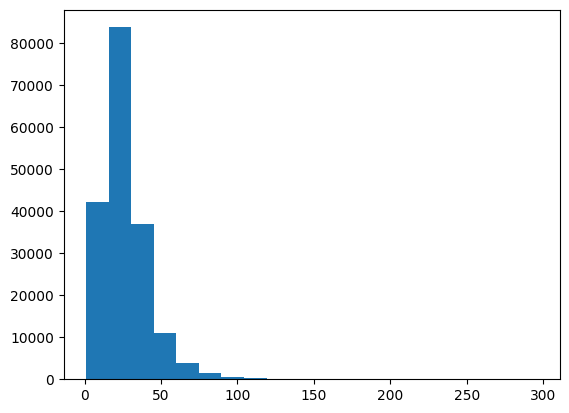

In [25]:
# visualize diff len of our sentences
import matplotlib.pyplot as plt
plt.hist(sen_len, bins=20)

In [26]:
# Get len that have 95% of our data
out_seq_len = int(np.percentile(sen_len, 95))
out_seq_len

55

### Creating text vectorizer

In [27]:
max_tokens = 68000   # from paper

# create text_vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=out_seq_len)

In [28]:
# adapt text_vectorizer on on our training data
text_vectorizer.adapt(train_sentences)

In [29]:
# check of it with random sentence
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
patients ( n = @ ) with mixed dyslipidemia on a standard statin dose ( @-@mg simvastatin or @-@mg atorvastatin or @-@mg rosuvastatin ) who had not achieved lipid targets were randomized to switch to the highest dose of rosuvastatin ( @mg/day ) or to add-on-statin extended release nicotinic acid ( er-na ) / laropiprant ( lrpt ) ( @/@mg/day for the first @weeks followed by @/@mg/day for the next @weeks ) or to add-on-statin micronized fenofibrate ( @mg/day ) for a total of @months .

Length of text: 86

Vectorized text:
[[   12    40     7   832  4831    18     8   165  1655   131    68  2624
     16    68  1419    16    68  2277    67    55    31   454   864  2357
      9    29     6  3148     6     2  1142   131     4  2277   744    16
      6 41404  1774  1434  8639   386 58476 30433 37247   744    11     2
    152    53   284    22   744    11     2]]


In [30]:
# get vocab_num
vocab_num = text_vectorizer.get_vocabulary()
len(vocab_num)

64841

### Creating embedding layer

In [31]:
from tensorflow.keras.layers import Embedding

# create embedding layer
embedding = Embedding(input_dim=len(vocab_num),
                      output_dim=128,
                      mask_zero=True,
                      name='embedding')

In [32]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
patients ( n = @ ) with mixed dyslipidemia on a standard statin dose ( @-@mg simvastatin or @-@mg atorvastatin or @-@mg rosuvastatin ) who had not achieved lipid targets were randomized to switch to the highest dose of rosuvastatin ( @mg/day ) or to add-on-statin extended release nicotinic acid ( er-na ) / laropiprant ( lrpt ) ( @/@mg/day for the first @weeks followed by @/@mg/day for the next @weeks ) or to add-on-statin micronized fenofibrate ( @mg/day ) for a total of @months .

Sentence after vectorization (before embedding):
[[   12    40     7   832  4831    18     8   165  1655   131    68  2624
     16    68  1419    16    68  2277    67    55    31   454   864  2357
      9    29     6  3148     6     2  1142   131     4  2277   744    16
      6 41404  1774  1434  8639   386 58476 30433 37247   744    11     2
    152    53   284    22   744    11     2]]

Sentence after embedding:
[[[ 0.01645333 -0.00848531  0.03740807 ...  0.02655737  0.032353

## Create fast loading for datasets

In [33]:
# convert our data into datasets for making patch and prefetching

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [34]:
# make batching and prefetching
train_dataset = train_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model_1 Building, compiling and fitting with `GlobalAvgPooling`

In [35]:
from tensorflow.keras.layers import Conv1D, Dense, Input, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras import Model

# create model_1
inputs = Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)

# create Conv1D and Avg pooling layers
x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)

outputs = Dense(class_nums, activation='softmax')(x)
model_1 = Model(inputs, outputs, name="model_1_Conv1D")


In [36]:
# compile our model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [37]:
# Fit the model
model_1_hist = model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                           epochs=3,
                           validation_data=dev_dataset,
                           validation_steps=int(0.1 * len(dev_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 71s 103ms/step - loss: 0.9500 - accuracy: 0.6247 - val_loss: 0.7253 - val_accuracy: 0.7241
Epoch 2/3
562/562 [==============================] - 10s 19ms/step - loss: 0.6867 - accuracy: 0.7459 - val_loss: 0.6586 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 0.6381 - accuracy: 0.7682 - val_loss: 0.6167 - val_accuracy: 0.7789


In [38]:
# evaluate on our dev_dataset
model_1.evaluate(dev_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.6157 - accuracy: 0.7806


[0.6156730651855469, 0.7805507779121399]

### Make prediction on model_1 and calcualte results

---



In [39]:
# Let's make a predictions
model_1_preds_probs = model_1.predict(dev_sentences)
model_1_preds_probs, model_1_preds_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.6920168e-01, 1.4829424e-01, 8.8766284e-02, 2.5675389e-01,
         3.6983889e-02],
        [4.4610971e-01, 2.3380508e-01, 1.5564248e-02, 2.9411611e-01,
         1.0404837e-02],
        [2.1376091e-01, 3.3882689e-02, 4.3714368e-03, 7.4776739e-01,
         2.1754683e-04],
        ...,
        [6.5346821e-06, 9.0425089e-04, 5.8294582e-04, 4.2713577e-06,
         9.9850202e-01],
        [6.3475639e-02, 4.2612699e-01, 1.2897487e-01, 8.6872727e-02,
         2.9454985e-01],
        [2.1867989e-01, 5.2913642e-01, 9.9176198e-02, 8.8961154e-02,
         6.4046361e-02]], dtype=float32),
 (30212, 5))

In [40]:
# convert preds_probs into labels
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds, model_1_preds.shape

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>,
 TensorShape([30212]))

In [41]:
# calculate results
model_1_res = calculate_results(y_true=dev_labels_decoded,
                                y_pred=model_1_preds)
model_1_res

{'accuracy': 78.0550774526678,
 'precision': 0.7764772872748577,
 'recall': 0.7805507745266781,
 'f1': 0.7770879275099934}

## Preparing for model_2 (text_tokens)

In [42]:
# get pretrained embedding layer for tensorflow hub "USE"
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="USE_vesrion4")

In [43]:
# Test our embedding layer
import random
rand_sent = random.choice(train_sentences)
print(f"Original_text: {rand_sent}\n")
print(f"Embedding_shape: {tf_hub_embedding_layer([rand_sent]).shape}\n")
print(f"Embedding_version: {tf_hub_embedding_layer([rand_sent[:1]])}")

Original_text: to compare the effects between dezocine and flurbiprofen axetil on postoperative sore throat ( post ) after maxillofacial procedures .

Embedding_shape: (1, 512)

Embedding_version: [[-1.84628908e-02 -4.90199327e-02  1.25550861e-02  3.31091210e-02
  -2.72849239e-02  5.18329293e-02 -6.72410382e-03 -7.22129494e-02
   4.64934893e-02  3.46277654e-02 -2.86236219e-03 -8.47080816e-03
   5.91695271e-02  1.67357363e-02 -5.32352775e-02  2.91343126e-03
  -2.42895540e-02  8.11681524e-02  1.13414237e-02  1.56439506e-04
   3.57653126e-02 -7.06537347e-03  8.13941192e-03  1.60133578e-02
  -5.87195754e-02  3.52798738e-02 -2.18079463e-02 -8.43718573e-02
   1.07320910e-03 -6.65806308e-02  2.84489654e-02 -1.02248807e-02
  -2.93956324e-02 -3.76207158e-02  5.42463809e-02  3.55090648e-02
   3.93870845e-02  2.80711818e-02  8.40573609e-02 -2.64941677e-02
  -4.31970181e-03  3.07324454e-02  1.37453275e-02  3.06852311e-02
  -3.49612720e-03  8.79319236e-02 -5.79996742e-02 -1.50115062e-02
  -1.696865

### Model_2 Building, compiling and fitting

In [44]:
# create model (Functional API)
from tensorflow.keras.layers import Conv1D, Dense, Input, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras import Model

inputs = Input(shape=[], dtype='string')
x = tf_hub_embedding_layer(inputs)
x = Dense(128, activation='relu')(x)
# x = GlobalMaxPooling1D()(x)
outputs = Dense(class_nums, activation='softmax')(x)
model_2 = Model(inputs, outputs, name="model_2_USE")

# compile our model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [45]:
# get a summary
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE_vesrion4 (KerasLayer)   (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [46]:
# Fit the model
model_2_hist = model_2.fit(train_dataset,
                           steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                           epochs=3,
                           validation_data=dev_dataset,
                           validation_steps=int(0.1 * len(dev_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 29s 40ms/step - loss: 0.9169 - accuracy: 0.6469 - val_loss: 0.7949 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7679 - accuracy: 0.7026 - val_loss: 0.7539 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 16s 29ms/step - loss: 0.7517 - accuracy: 0.7127 - val_loss: 0.7374 - val_accuracy: 0.7134


In [47]:
# evalue on our model
model_2.evaluate(dev_dataset)

945/945 [==============================] - 26s 27ms/step - loss: 0.7406 - accuracy: 0.7143


[0.7406192421913147, 0.7143188118934631]

### Make prediction on model_2 and calcualte results


In [48]:
# get evaluation on our data
model_2_preds_probs = model_2.predict(dev_dataset)
model_2_preds_probs, model_2_preds_probs.shape

945/945 [==============================] - 22s 23ms/step


(array([[4.5327103e-01, 3.3716202e-01, 2.1938810e-03, 1.9989614e-01,
         7.4769254e-03],
        [3.5656211e-01, 5.0219417e-01, 3.5275891e-03, 1.3508105e-01,
         2.6350934e-03],
        [2.2592926e-01, 1.3246410e-01, 1.6378341e-02, 5.9132385e-01,
         3.3904426e-02],
        ...,
        [1.6600436e-03, 4.6292781e-03, 5.1120751e-02, 7.9810992e-04,
         9.4179189e-01],
        [4.7837398e-03, 5.0796852e-02, 1.9780728e-01, 1.5347559e-03,
         7.4507737e-01],
        [1.6406660e-01, 2.9202148e-01, 4.8315173e-01, 6.9920761e-03,
         5.3768087e-02]], dtype=float32),
 (30212, 5))

In [49]:
# convert preds_probs into labels
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds, model_2_preds.shape

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>,
 TensorShape([30212]))

In [50]:
# calculate results
model_2_res = calculate_results(y_true=dev_labels_decoded,
                                y_pred=model_2_preds)
model_2_res

{'accuracy': 71.4318813716404,
 'precision': 0.7146424001216027,
 'recall': 0.714318813716404,
 'f1': 0.7112162462960788}

## Preparing for model_3 `char_tokenizer`

### Create function for text splitting into chars

In [51]:
# make function for convert text into chars
def spilt_text(text):
  """
  Function that take text then return it with spaces between every char
  """
  return " ".join(list(text))

In [52]:
# get chars of one sentence into list
list(rand_sent)

['t',
 'o',
 ' ',
 'c',
 'o',
 'm',
 'p',
 'a',
 'r',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'e',
 'c',
 't',
 's',
 ' ',
 'b',
 'e',
 't',
 'w',
 'e',
 'e',
 'n',
 ' ',
 'd',
 'e',
 'z',
 'o',
 'c',
 'i',
 'n',
 'e',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'f',
 'l',
 'u',
 'r',
 'b',
 'i',
 'p',
 'r',
 'o',
 'f',
 'e',
 'n',
 ' ',
 'a',
 'x',
 'e',
 't',
 'i',
 'l',
 ' ',
 'o',
 'n',
 ' ',
 'p',
 'o',
 's',
 't',
 'o',
 'p',
 'e',
 'r',
 'a',
 't',
 'i',
 'v',
 'e',
 ' ',
 's',
 'o',
 'r',
 'e',
 ' ',
 't',
 'h',
 'r',
 'o',
 'a',
 't',
 ' ',
 '(',
 ' ',
 'p',
 'o',
 's',
 't',
 ' ',
 ')',
 ' ',
 'a',
 'f',
 't',
 'e',
 'r',
 ' ',
 'm',
 'a',
 'x',
 'i',
 'l',
 'l',
 'o',
 'f',
 'a',
 'c',
 'i',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'o',
 'c',
 'e',
 'd',
 'u',
 'r',
 'e',
 's',
 ' ',
 '.']

In [53]:
# get chars of one sentence into sentence with splitting chars with spaces
" ".join(list(rand_sent))

't o   c o m p a r e   t h e   e f f e c t s   b e t w e e n   d e z o c i n e   a n d   f l u r b i p r o f e n   a x e t i l   o n   p o s t o p e r a t i v e   s o r e   t h r o a t   (   p o s t   )   a f t e r   m a x i l l o f a c i a l   p r o c e d u r e s   .'

### Convert all our sentences into chars


In [54]:
train_chars = [spilt_text(sent) for sent in train_sentences]
dev_chars = [spilt_text(sent) for sent in dev_sentences]
test_chars = [spilt_text(sent) for sent in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [55]:
# what's avg length in our char_data
char_lens = [len(sent) for sent in train_sentences]
char_lens_avg = np.mean(char_lens)
char_lens_avg

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

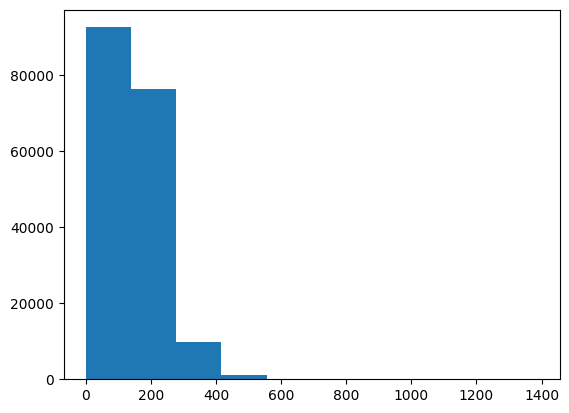

In [56]:
# what's distibutiuon of our sentences lengths
plt.hist(char_lens, bins=10)

In [57]:
# get length thta have 95% of our data
out_char_seq_len = int(np.percentile(char_lens, 95))
out_char_seq_len

290

### Let's make out `char_vectorizer` from TextVectorizer

In [58]:
# get all keyborad chars
import string
alphabet = string.ascii_lowercase + string.punctuation + string.digits
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789', 68)

In [60]:
# making char_vectorizer
MAX_NUMS_CHARS = len(alphabet)

char_vectorizer = TextVectorization(max_tokens=MAX_NUMS_CHARS,
                                    output_sequence_length=out_char_seq_len,
                                    name="char_vectorizer")

In [61]:
# adapting our char vectorizer on our chars
char_vectorizer.adapt(train_chars)

In [62]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a   l a r g e   m a j o r i t y   o f   s u p p l e m e n t e d   s u b j e c t s   r e p o r t e d   a   r e d u c t i o n   i n   h a i r   l o s s   (   @   %   o f   s u b j e c t s   a t   @ m o n t h s   )   ,   a s   w e l l   a s   a n   i m p r o v e m e n t   i n   h a i r   d i a m e t e r   (   @   %   )   a n d   h a i r   d e n s i t y   (   @   %   )   .

Length of chars: 146

Vectorized chars:
[[ 5 12  5  8 18  2 15  5 27  7  8  4  3 19  7 17  9 16 14 14 12  2 15  2
   6  3  2 10  9 16 22 27  2 11  3  9  8  2 14  7  8  3  2 10  5  8  2 10
  16 11  3  4  7  6  4  6 13  5  4  8 12  7  9  9  7 17  9 16 22 27  2 11
   3  9  5  3 15  7  6  3 13  9  5  9 20  2 12 12  5  9  5  6  4 15 14  8
   7 21  2 15  2  6  3  4  6 13  5  4  8 10  4  5 15  2  3  2  8  5  6 10
  13  5  4  8 10  2  6  9  4  3 19  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [63]:
# Get our vocabs
char_vocab = char_vectorizer.get_vocabulary()
print(f"len of vocab: {len(char_vocab)}\n")
print(f"most_common words: {char_vocab[:5]}\n")
print(f"least_common words: {char_vocab[-5:]}")

len of vocab: 28

most_common words: ['', '[UNK]', 'e', 't', 'i']

least_common words: ['k', 'x', 'z', 'q', 'j']


### Let's make our Embedding layer

In [64]:
from tensorflow.keras.layers import Embedding
char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=28, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                           mask_zero=True,
                           name="chae_embedding")

In [65]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a   l a r g e   m a j o r i t y   o f   s u p p l e m e n t e d   s u b j e c t s   r e p o r t e d   a   r e d u c t i o n   i n   h a i r   l o s s   (   @   %   o f   s u b j e c t s   a t   @ m o n t h s   )   ,   a s   w e l l   a s   a n   i m p r o v e m e n t   i n   h a i r   d i a m e t e r   (   @   %   )   a n d   h a i r   d e n s i t y   (   @   %   )   .

Embedded chars (after vectorization and embedding):
[[[-0.01058454 -0.04174997  0.01024456 ...  0.04383984  0.01585286
    0.01991985]
  [ 0.04592696 -0.04196813  0.00614616 ...  0.001325    0.01946038
   -0.04607862]
  [-0.01058454 -0.04174997  0.01024456 ...  0.04383984  0.01585286
    0.01991985]
  ...
  [ 0.02641441  0.00749553 -0.00983083 ...  0.02727601  0.02293985
   -0.0362188 ]
  [ 0.02641441  0.00749553 -0.00983083 ...  0.02727601  0.02293985
   -0.0362188 ]
  [ 0.02641441  0.00749553 -0.00983083 ...  0.02727601  0.02293985
   -0.0362188 ]]]

Character embed

### Model_3 Building and compiling and fitting

In [66]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(class_nums, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 chae_embedding (Embedding)  (None, 290, 28)           784       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           9024      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [68]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
dev_char_dataset = tf.data.Dataset.from_tensor_slices((dev_chars, dev_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [69]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=dev_char_dataset,
                              validation_steps=int(0.1 * len(dev_char_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 16ms/step - loss: 1.2429 - accuracy: 0.5002 - val_loss: 1.0204 - val_accuracy: 0.6021
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9873 - accuracy: 0.6050 - val_loss: 0.9221 - val_accuracy: 0.6333
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.9147 - accuracy: 0.6402 - val_loss: 0.8535 - val_accuracy: 0.6662


In [70]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(dev_char_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.8734 - accuracy: 0.6633


[0.873359203338623, 0.6632794737815857]

In [71]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(dev_char_dataset)
model_3_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[0.16672301, 0.43566692, 0.123051  , 0.19926047, 0.07529869],
       [0.18658614, 0.57893455, 0.01576663, 0.15607387, 0.06263879],
       [0.0820467 , 0.34310806, 0.18437827, 0.29755417, 0.09291282],
       ...,
       [0.01678045, 0.01724072, 0.1225151 , 0.01715307, 0.82631063],
       [0.02400255, 0.14505124, 0.46067348, 0.03770968, 0.33256298],
       [0.23557483, 0.63683766, 0.0788159 , 0.04180104, 0.00697057]],
      dtype=float32)

In [72]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 1])>

In [73]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=dev_labels_decoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 66.32794915927445,
 'precision': 0.6544558370951422,
 'recall': 0.6632794915927446,
 'f1': 0.6520567061854602}

## Model_4 Building a multi_input model

In [76]:
from tensorflow.keras import layers, Model

# 1. token_input
token_input = layers.Input(shape=[], dtype='string', name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_input)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = Model(token_input, token_outputs, name="token_model")

# 2. char_input
char_input = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectorization = char_vectorizer(char_input)
char_embed = char_embedding(char_vectorization)
char_Bi_LSTM = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = Model(char_input, char_Bi_LSTM, name="char_model")

# 3. combine 2 inputs with `concatenation layer`
combined_embeddings = layers.Concatenate(name='combined_embeddings')([token_model.output, char_model.output])

# 4. make regularization with DropOut
combined_dropout = layers.Dropout(0.5)(combined_embeddings)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
output_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(class_nums, activation='softmax')(output_dropout)

# 5. make our model
model_4 = Model(inputs=[token_model.input,
                        char_model.input],
                outputs=output_layer,
                name='model_4_multi_input_model')

In [77]:
# Show our model
model_4.summary()

Model: "model_4_multi_input_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE_vesrion4 (KerasLayer)   (None, 512)                  2567978   ['toke

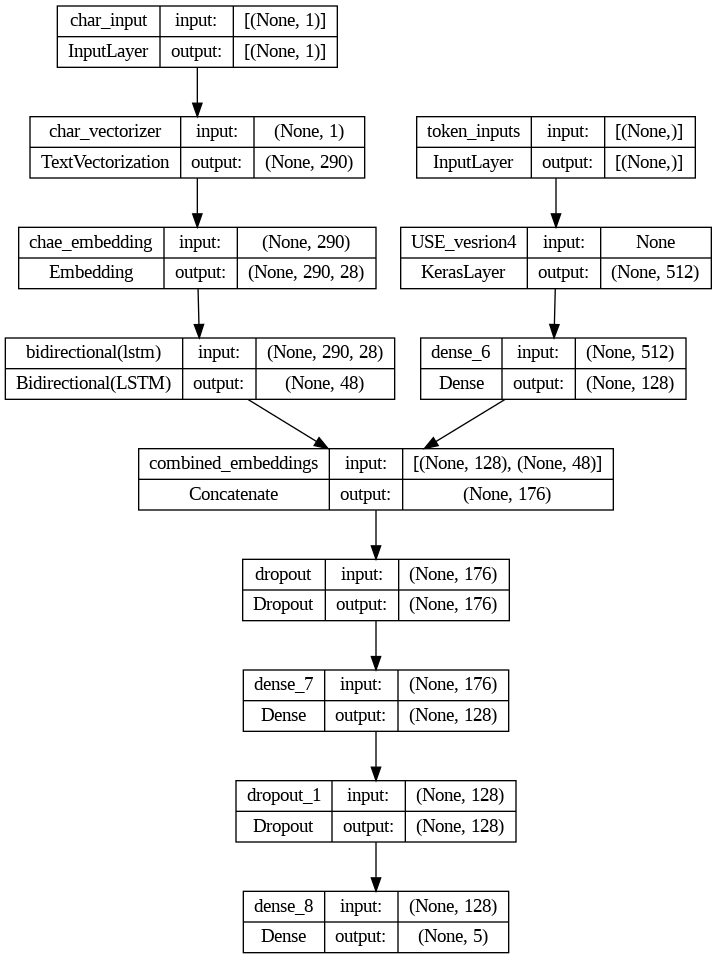

In [79]:
# visualize our model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

### Creating datasets for our model and batching, prefetching them

In [83]:
# convert our train_data into datasets for both data
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# bathcing and prefetching data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [84]:
# convert our dev_data into datasets for both data
dev_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_chars))
dev_char_token_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
dev_char_token_dataset = tf.data.Dataset.zip((dev_char_token_data, dev_char_token_labels))

# bathcing and prefetching data
dev_char_token_dataset = dev_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

dev_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Compiling and fitting our model_4

In [85]:
# compile model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [86]:
# Fit the model on chars only
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=dev_char_token_dataset,
                              validation_steps=int(0.1 * len(dev_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 66s 93ms/step - loss: 0.9802 - accuracy: 0.6121 - val_loss: 0.7748 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 44s 79ms/step - loss: 0.8029 - accuracy: 0.6924 - val_loss: 0.7205 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 35s 62ms/step - loss: 0.7788 - accuracy: 0.7026 - val_loss: 0.6969 - val_accuracy: 0.7317


In [87]:
# make predictions
model_4_preds_probs = model_4.predict(dev_char_token_dataset)
model_4_preds_probs

945/945 [==============================] - 24s 21ms/step


array([[3.9528844e-01, 3.9827174e-01, 4.9615754e-03, 1.9253819e-01,
        8.9400215e-03],
       [3.4325853e-01, 4.9164823e-01, 5.2653574e-03, 1.5663651e-01,
        3.1914313e-03],
       [2.6478595e-01, 2.1513763e-01, 6.7911863e-02, 4.1034046e-01,
        4.1824058e-02],
       ...,
       [4.2421665e-04, 6.3151103e-03, 6.0215309e-02, 2.9319868e-04,
        9.3275219e-01],
       [5.8950954e-03, 4.8443232e-02, 2.1858785e-01, 4.1748821e-03,
        7.2289896e-01],
       [3.0646732e-01, 3.4430137e-01, 2.4839871e-01, 2.9373964e-02,
        7.1458578e-02]], dtype=float32)

In [88]:
# convert preds into labels
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

### Calculate results for model_4

In [89]:
# calc results
model_4_res = calculate_results(y_true=dev_labels_decoded,
                                y_pred=model_4_preds)
model_4_res

{'accuracy': 73.30199920561367,
 'precision': 0.7348816864009234,
 'recall': 0.7330199920561367,
 'f1': 0.7293101657112474}

In [91]:
model_3_results

{'accuracy': 66.32794915927445,
 'precision': 0.6544558370951422,
 'recall': 0.6632794915927446,
 'f1': 0.6520567061854602}

## Model_5 Preparing

### Encoding `line_numbers` feature that used with model_5

In [93]:
train_df.head()

,target,text,line_num,tot_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [106]:
# show line numbers values
train_df['line_num'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_num, dtype: int64

<Axes: ylabel='Frequency'>

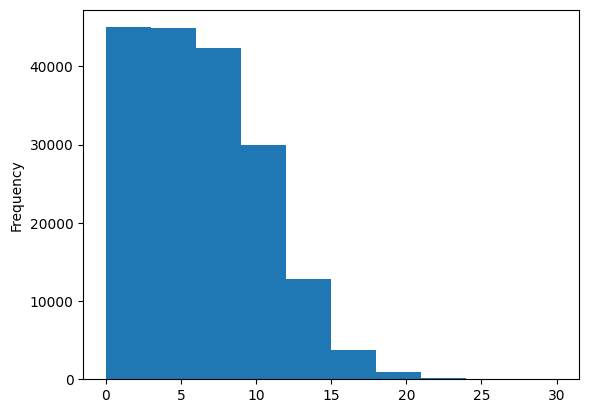

In [107]:
# show distributions of 'line_nums'
train_df['line_num'].plot.hist()

In [108]:
# use tf to create one_hot for line_nums feauture
train_line_num_one_hot = tf.one_hot(train_df['line_num'].to_numpy(), depth=15)
train_line_num_one_hot[:15], train_line_num_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [109]:
# make same for dev_set, test_set
dev_line_num_one_hot = tf.one_hot(dev_df['line_num'].to_numpy(), depth=15)
test_line_num_one_hot = tf.one_hot(test_df['line_num'].to_numpy(), depth=15)

### Encoding `tot_lines` feature that used with model_5

In [110]:
train_df.head()

,target,text,line_num,tot_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [111]:
# show number of value_counts tot_lines
train_df['tot_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: tot_lines, dtype: int64

<Axes: ylabel='Frequency'>

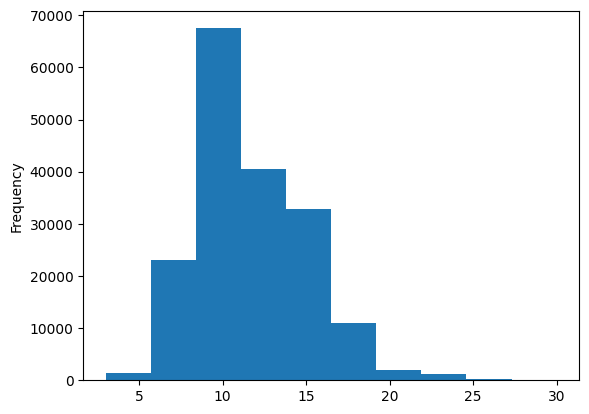

In [112]:
# show distribution
train_df['tot_lines'].plot.hist()

In [113]:
# use tf to create one_hot for line_nums feauture
train_tot_lines_one_hot = tf.one_hot(train_df['tot_lines'].to_numpy(), depth=20)
train_tot_lines_one_hot[:15], train_tot_lines_one_hot.shape

(<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [114]:
# make same for dev_set, test_set
dev_tot_lines_one_hot = tf.one_hot(dev_df['tot_lines'].to_numpy(), depth=20)
test_tot_lines_one_hot = tf.one_hot(test_df['tot_lines'].to_numpy(), depth=20)

In [115]:
# for input layer of line_num_input
train_line_num_one_hot.shape, train_line_num_one_hot.dtype

(TensorShape([180040, 15]), tf.float32)

In [116]:
train_tot_lines_one_hot.shape, train_tot_lines_one_hot.dtype

(TensorShape([180040, 20]), tf.float32)

### Creating our model_5

In [117]:
from tensorflow.keras import layers, Model

# 1. token_input
token_input = layers.Input(shape=[], dtype='string', name="token_inputs")
token_embedding = tf_hub_embedding_layer(token_input)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = Model(token_input, token_outputs, name="token_model")

# 2. char_input
char_input = layers.Input(shape=(1,), dtype='string', name='char_input')
char_vectorization = char_vectorizer(char_input)
char_embed = char_embedding(char_vectorization)
char_Bi_LSTM = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = Model(char_input, char_Bi_LSTM, name="char_model")

# 3. line_nums_input
line_nums_input = layers.Input(shape=(15,), dtype=tf.float32, name='line_nums_input')
line_nums_output = layers.Dense(32, activation='relu')(line_nums_input)
line_nums_model = Model(line_nums_input, line_nums_output, name='line_nums_model')

# 4. tot_lines_input
tot_lines_input = layers.Input(shape=(20,), dtype=tf.float32, name='tot_lines_input')
tot_lines_output = layers.Dense(32, activation='relu')(tot_lines_input)
tot_lines_model = Model(tot_lines_input, tot_lines_output, name='tot_lines_model')

# 5. combine 1,2 inputs with `concatenation layer`
combined_embeddings = layers.Concatenate(name='combined_embeddings')([token_model.output, char_model.output])

# make regularization with DropOut
combined_dense = layers.Dense(128, activation='relu')(combined_embeddings)
combined_dropout = layers.Dropout(0.5)(combined_dense)

# 6. combined positional encoding with combined_dropout(token, char)
tribrid_embeddings = layers.Concatenate(name='tribrid_embeddings')([line_nums_model.output,
                                                                    tot_lines_model.output,
                                                                    combined_dropout])

# 7. craete output_layer
output_layer = layers.Dense(class_nums, activation='softmax')(tribrid_embeddings)

# 8. make our model
model_5 = Model(inputs=[token_model.input,
                        char_model.input,
                        line_nums_model.input,
                        tot_lines_model.input],
                outputs=output_layer,
                name='model_5_tribrid_input_model')

In [118]:
# show our model
model_5.summary()

Model: "model_5_tribrid_input_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 USE_vesrion4 (KerasLayer)   (None, 512)                  2567978   ['to

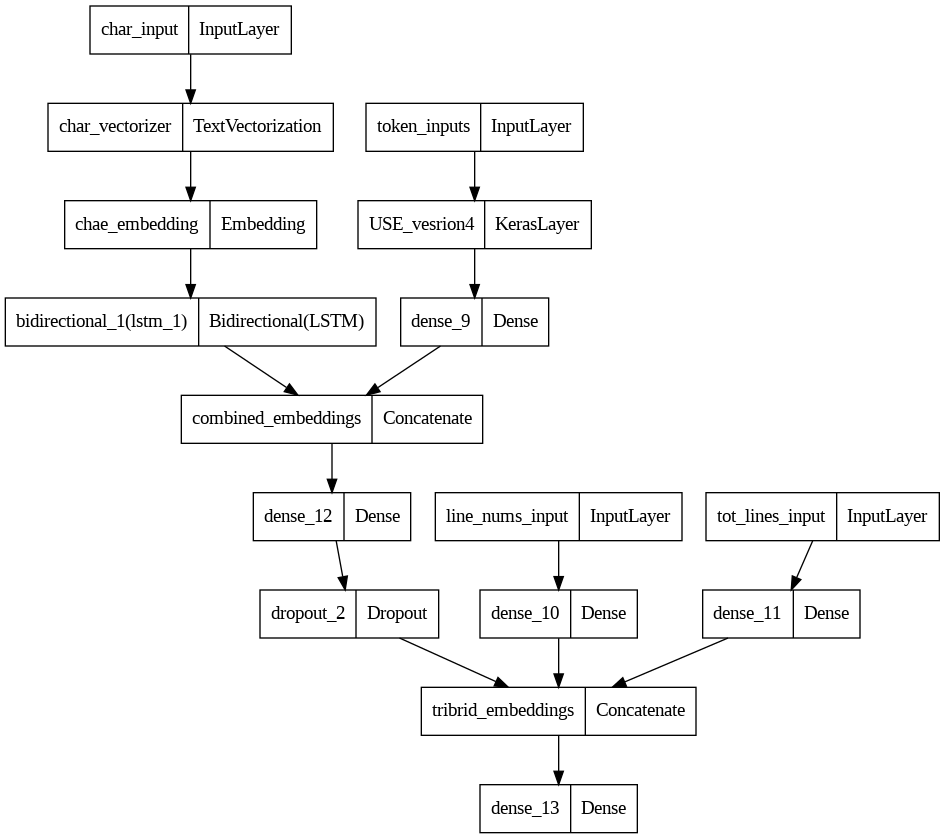

In [120]:
# visualize our model
from keras.utils import plot_model
plot_model(model_5)

### Convert our data into datasets

In [121]:
# convert our train_data into datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                train_chars,
                                                                train_line_num_one_hot,
                                                                train_tot_lines_one_hot))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
# make data set
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

# batching and prefetching
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [122]:
# convert our dev_data into datasets
dev_char_token_pos_data = tf.data.Dataset.from_tensor_slices((dev_sentences,
                                                                dev_chars,
                                                                dev_line_num_one_hot,
                                                                dev_tot_lines_one_hot))
dev_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(dev_labels_one_hot)
# make data set
dev_char_token_pos_dataset = tf.data.Dataset.zip((dev_char_token_pos_data, dev_char_token_pos_labels))

# batching and prefetching
dev_char_token_pos_dataset = dev_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

dev_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Compiling and fitting our model

In [123]:
# compile model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [124]:
# Fit the model on chars only
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=dev_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(dev_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 55s 77ms/step - loss: 1.1079 - accuracy: 0.7173 - val_loss: 0.9880 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 47s 83ms/step - loss: 0.9761 - accuracy: 0.8106 - val_loss: 0.9536 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 42s 75ms/step - loss: 0.9595 - accuracy: 0.8190 - val_loss: 0.9407 - val_accuracy: 0.8221


In [125]:
# make predictions
model_5_preds_probs = model_5.predict(dev_char_token_pos_dataset)
model_5_preds_probs

945/945 [==============================] - 23s 21ms/step


array([[0.5189583 , 0.1141791 , 0.01063605, 0.3358398 , 0.02038677],
       [0.5788359 , 0.10206276, 0.04461652, 0.26267564, 0.01180925],
       [0.30454192, 0.12032928, 0.16160111, 0.33927387, 0.0742538 ],
       ...,
       [0.03710824, 0.11278101, 0.04495364, 0.03406086, 0.7710962 ],
       [0.03442899, 0.31319168, 0.09033402, 0.03048791, 0.53155744],
       [0.19910005, 0.60337216, 0.09116933, 0.03820568, 0.06815277]],
      dtype=float32)

In [126]:
# convert preds into labels
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

### Calculate results for model_5

In [127]:
model_5_res = calculate_results(y_true=dev_labels_decoded,
                                y_pred=model_5_preds)
model_5_res

{'accuracy': 83.11929034820601,
 'precision': 0.8303846528973969,
 'recall': 0.8311929034820601,
 'f1': 0.8296931531425428}

## Comparing our all results of models

In [139]:
# creating dataframe for all results
import pandas as pd

all_model_results = pd.DataFrame({'model_0':model_0_res,
                                  'model_1':model_1_res,
                                  'model_2':model_2_res,
                                  'model_3':model_3_results,
                                  'model_4_multi_input':model_4_res,
                                  'model_5_tribrid_input':model_5_res})
all_model_results

,model_0,model_1,model_2,model_3,model_4_multi_input,model_5_tribrid_input
accuracy,72.183238,78.055077,71.431881,66.327949,73.301999,83.119290
precision,0.718647,0.776477,0.714642,0.654456,0.734882,0.830385
recall,0.721832,0.780551,0.714319,0.663279,0.733020,0.831193
f1,0.698925,0.777088,0.711216,0.652057,0.729310,0.829693


In [140]:
# make transpose
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0,72.183238,0.718647,0.721832,0.698925
model_1,78.055077,0.776477,0.780551,0.777088
model_2,71.431881,0.714642,0.714319,0.711216
model_3,66.327949,0.654456,0.663279,0.652057
model_4_multi_input,73.301999,0.734882,0.733020,0.729310
model_5_tribrid_input,83.119290,0.830385,0.831193,0.829693


In [141]:
# let's convert our accuarcy with same normailization with others
all_model_results['accuracy']  = all_model_results['accuracy'] / 100
all_model_results

,accuracy,precision,recall,f1
model_0,0.721832,0.718647,0.721832,0.698925
model_1,0.780551,0.776477,0.780551,0.777088
model_2,0.714319,0.714642,0.714319,0.711216
model_3,0.663279,0.654456,0.663279,0.652057
model_4_multi_input,0.733020,0.734882,0.733020,0.729310
model_5_tribrid_input,0.831193,0.830385,0.831193,0.829693


<Axes: >

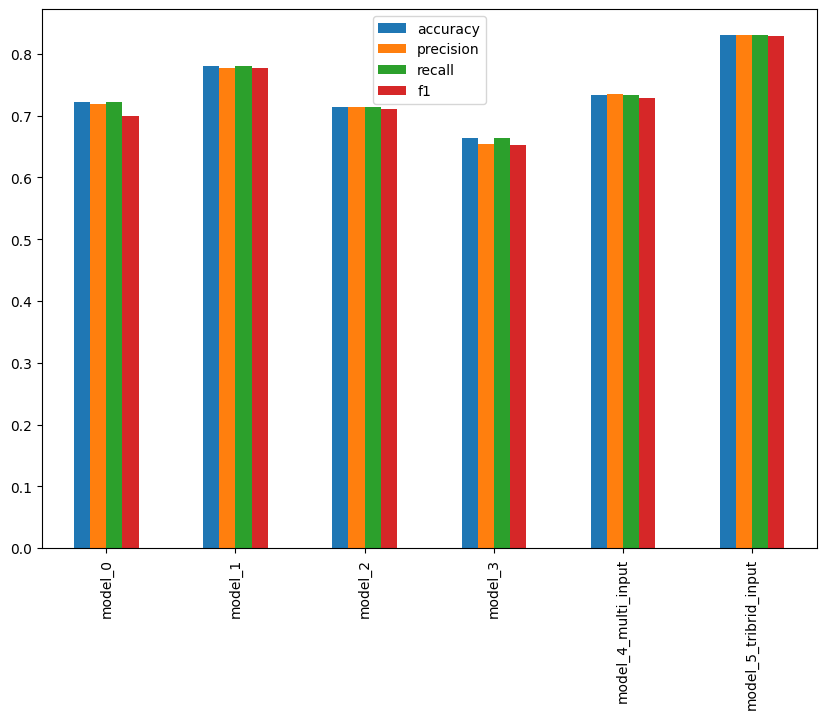

In [142]:
# visualizing our results
all_model_results.plot(kind='bar', figsize=(10, 7))

<Axes: >

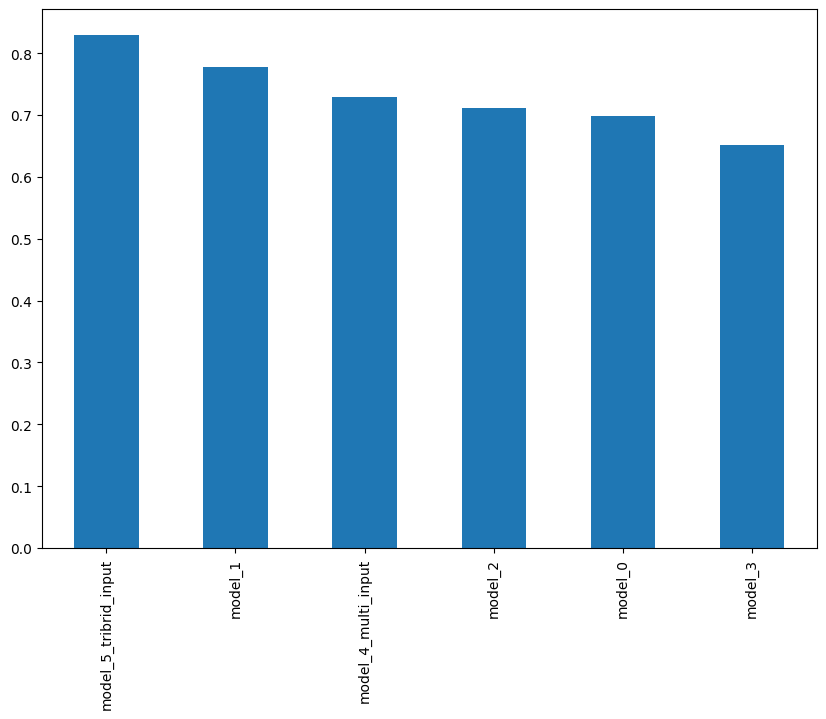

In [146]:
# let's sorting on our f1_score
sorted_f1 = all_model_results.sort_values(by=['f1'], ascending=False)['f1']
sorted_f1.plot(kind='bar', figsize=(10, 7))